# Full Pipeline Evaluation

This notebook evaluates the complete mean reversion trading pipeline on the test day: October 8, 2025. We calculate key performance metrics and visualize the results.

**Pipeline Components:**
1. GMM identifies overextension candidates (5% threshold)
2. Random Forest predicts probability of profitable reversion
3. GBM Quantile Regression predicts dynamic exit levels (Q10 stop-loss, Q50 target)

**Metrics Computed:**
- Hit Rate: Fraction of trades that hit the profit target
- Win/Loss Ratio: Average win magnitude vs. average loss magnitude
- Total P&L: Cumulative returns across all trades
- Sharpe Ratio: Risk-adjusted performance measure

In [1]:
import os
import logging
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('..')
print(f"Working directory: {os.getcwd()}")

from src.fullPipeline.evaluate import (
    load_test_data,
    compute_trade_direction,
    simulate_trades,
    compute_metrics,
    compute_metrics_by_ticker,
    format_metrics_table,
    format_ticker_table,
)

# Config
RANDOM_STATE = 42
RF_THRESHOLD = 0.3
DATA_PATH = Path("data/gbm/gbm_predictions.parquet")
TEST_DAY = "2025-10-08"

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("fullPipeline")

np.random.seed(RANDOM_STATE)

# Plot styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100

Working directory: c:\Users\doqui\OneDrive\Documents\cs4641-131-project


## 1. Load Out-of-Sample Data

We load the GBM predictions and filter to the test day only to ensure true out-of-sample evaluation.

In [2]:
# Load and filter to test day
df_test = load_test_data(
    data_path=str(DATA_PATH),
    test_day=TEST_DAY,
    logger=logger,
)

print(f"\nTest day data shape: {df_test.shape}")
print(f"Columns: {list(df_test.columns)}")
print(f"\nLabel distribution:")
print(df_test['label'].value_counts().sort_index())

2025-11-28 23:14:17,643 [INFO] Loaded 1,841 total rows from data\gbm\gbm_predictions.parquet
2025-11-28 23:14:17,651 [INFO] Filtered to test day (2025-10-08): 417 rows



Test day data shape: (417, 24)
Columns: ['ticker', 'date', 't', 't_end', 'gmm_loglik', 'gmm_is_candidate', 'gmm_component', 'label', 'feat_vwap_zscore', 'feat_bollinger_position', 'feat_momentum_3bar', 'feat_momentum_5bar', 'feat_relative_volume', 'feat_time_of_day', 'feat_context_bar_count', 'feat_context_avg_volume', 'feat_context_price_range', 'day', 'y', 'rf_proba_reversion', 'ewm_std', 'forward_return', 'gbm_pred_q10', 'gbm_pred_q50']

Label distribution:
label
-1    195
 0      4
 1    218
Name: count, dtype: int64


In [3]:
# Check key columns
print("Key column statistics (test day):")
print(f"\nforward_return: mean={df_test['forward_return'].mean():.6f}, std={df_test['forward_return'].std():.6f}")
print(f"rf_proba_reversion: mean={df_test['rf_proba_reversion'].mean():.3f}, std={df_test['rf_proba_reversion'].std():.3f}")
print(f"gbm_pred_q10 (stop): mean={df_test['gbm_pred_q10'].mean():.6f}")
print(f"gbm_pred_q50 (target): mean={df_test['gbm_pred_q50'].mean():.6f}")
print(f"\nTickers in test: {df_test['ticker'].nunique()}")
print(df_test['ticker'].value_counts())

Key column statistics (test day):

forward_return: mean=0.000067, std=0.001037
rf_proba_reversion: mean=0.496, std=0.099
gbm_pred_q10 (stop): mean=-0.001093
gbm_pred_q50 (target): mean=0.000853

Tickers in test: 20
ticker
PCG     143
SMCI     79
INTC     60
FCX      16
DXCM     15
XYZ      13
DECK     13
DAL      12
CCL      11
CNC      10
NCLH     10
EQT       9
DLTR      8
TTD       5
KVUE      4
ON        3
MCHP      2
DOW       2
SLB       1
UBER      1
Name: count, dtype: int64


## 2. Trading Simulation

We simulate trades using the pipeline predictions:
- **Trade direction** is determined by VWAP z-score: negative = LONG, positive = SHORT
- **Entry** occurs when RF probability >= threshold
- **Exit** is based on triple-barrier outcome (label)

In [4]:
# Run trading simulation
df_trades = simulate_trades(
    df_test,
    rf_threshold=RF_THRESHOLD,
    logger=logger,
)

print(f"\nSimulated {len(df_trades)} trades")
print(f"\nTrade direction distribution:")
print(df_trades['trade_direction_label'].value_counts())
print(f"\nOutcome distribution:")
print(df_trades['outcome'].value_counts())

2025-11-28 23:14:24,315 [INFO] Trades with RF prob >= 0.3: 417 / 417



Simulated 417 trades

Trade direction distribution:
trade_direction_label
SHORT    224
LONG     193
Name: count, dtype: int64

Outcome distribution:
outcome
WIN        218
LOSS       195
TIMEOUT      4
Name: count, dtype: int64


## 3. Performance Metrics

Calculate Hit Rate, Win/Loss Ratio, Total P&L, and Sharpe Ratio.

In [6]:
# Compute overall metrics
metrics = compute_metrics(df_trades, logger=logger)

print("\n" + "="*60)
print("FULL PIPELINE PERFORMANCE SUMMARY")
print("="*60)
print(f"\nTest Day: {TEST_DAY}")
print(f"RF Threshold: {RF_THRESHOLD}")
print(f"\n{format_metrics_table(metrics)}")

2025-11-28 23:14:45,657 [INFO] Metrics computed: 417 trades, 52.3% hit rate, Sharpe=1.32, Total P&L=0.027854



FULL PIPELINE PERFORMANCE SUMMARY

Test Day: 2025-10-08
RF Threshold: 0.3

| Metric | Value |
|--------|-------|
| Total Trades | 417 |
| Wins | 218 |
| Losses | 195 |
| Timeouts | 4 |
| Hit Rate | 52.3% |
| Avg Win | 0.000996 |
| Avg Loss | -0.000971 |
| Win/Loss Ratio | 1.03 |
| Total P&L | 0.027854 |
| Mean P&L | 0.000067 |
| Std P&L | 0.001037 |
| Sharpe Ratio | 1.32 |


In [7]:
# Compute metrics by ticker
df_ticker_metrics = compute_metrics_by_ticker(df_trades, logger=logger)

print("\nPerformance by Ticker:")
print(format_ticker_table(df_ticker_metrics))

2025-11-28 23:14:49,522 [INFO] Computed metrics for 20 tickers



Performance by Ticker:
| Ticker | Trades | Wins | Losses | Hit Rate | Total P&L | Sharpe |
|--------|--------|------|--------|----------|-----------|--------|
| SMCI | 79 | 48 | 31 | 60.8% | 0.026667 | 2.36 |
| DXCM | 15 | 13 | 2 | 86.7% | 0.011981 | 3.85 |
| XYZ | 13 | 10 | 3 | 76.9% | 0.008798 | 2.00 |
| PCG | 143 | 75 | 68 | 52.4% | 0.002838 | 0.31 |
| CCL | 11 | 6 | 5 | 54.5% | 0.001907 | 0.54 |
| KVUE | 4 | 3 | 1 | 75.0% | 0.001561 | 1.01 |
| FCX | 16 | 8 | 8 | 50.0% | 0.000835 | 0.22 |
| UBER | 1 | 1 | 0 | 100.0% | 0.000572 | nan |
| TTD | 5 | 2 | 3 | 40.0% | 0.000157 | 0.07 |
| MCHP | 2 | 1 | 1 | 50.0% | 0.000029 | 0.01 |
| DAL | 12 | 7 | 5 | 58.3% | -0.000039 | -0.01 |
| SLB | 1 | 0 | 1 | 0.0% | -0.000679 | nan |
| CNC | 10 | 5 | 5 | 50.0% | -0.000763 | -0.24 |
| DECK | 13 | 4 | 5 | 30.8% | -0.000946 | -0.16 |
| DOW | 2 | 0 | 2 | 0.0% | -0.001113 | -66.23 |
| NCLH | 10 | 4 | 6 | 40.0% | -0.001573 | -0.61 |
| EQT | 9 | 4 | 5 | 44.4% | -0.001988 | -0.43 |
| ON | 3 | 0 | 3 | 0.0%

In [9]:
# Display as pandas DataFrames for better formatting
print("\n--- Summary Metrics ---")
summary_df = pd.DataFrame([{
    "Metric": "Total Trades", "Value": f"{metrics['n_trades']:,}"
}, {
    "Metric": "Wins / Losses / Timeouts", "Value": f"{metrics['n_wins']} / {metrics['n_losses']} / {metrics['n_timeouts']}"
}, {
    "Metric": "Hit Rate", "Value": f"{metrics['hit_rate']:.1%}"
}, {
    "Metric": "Win/Loss Ratio", "Value": f"{metrics['win_loss_ratio']:.2f}"
}, {
    "Metric": "Total P&L", "Value": f"{metrics['total_pnl']:.6f}"
}, {
    "Metric": "Sharpe Ratio", "Value": f"{metrics['sharpe_ratio']:.2f}"
}])
display(summary_df)

print("\n--- Per-Ticker Metrics ---")
display(df_ticker_metrics.round(4))


--- Summary Metrics ---


,Metric,Value
0,Total Trades,417
1,Wins / Losses / Timeouts,218 / 195 / 4
2,Hit Rate,52.3%
3,Win/Loss Ratio,1.03
4,Total P&L,0.027854
5,Sharpe Ratio,1.32



--- Per-Ticker Metrics ---


,ticker,n_trades,n_wins,n_losses,hit_rate,total_pnl,mean_pnl,sharpe
16,SMCI,79,48,31,0.6076,0.0267,0.0003,2.3616
6,DXCM,15,13,2,0.8667,0.0120,0.0008,3.8500
19,XYZ,13,10,3,0.7692,0.0088,0.0007,2.0010
14,PCG,143,75,68,0.5245,0.0028,0.0000,0.3149
0,CCL,11,6,5,0.5455,0.0019,0.0002,0.5389
10,KVUE,4,3,1,0.7500,0.0016,0.0004,1.0075
8,FCX,16,8,8,0.5000,0.0008,0.0001,0.2218
18,UBER,1,1,0,1.0000,0.0006,0.0006,NaN
17,TTD,5,2,3,0.4000,0.0002,0.0000,0.0725
11,MCHP,2,1,1,0.5000,0.0000,0.0000,0.0114


## 4. Visualizations

1. Cumulative P&L over trades
2. Win/Loss distribution histogram
3. Predicted vs Actual exit levels
4. Performance by ticker

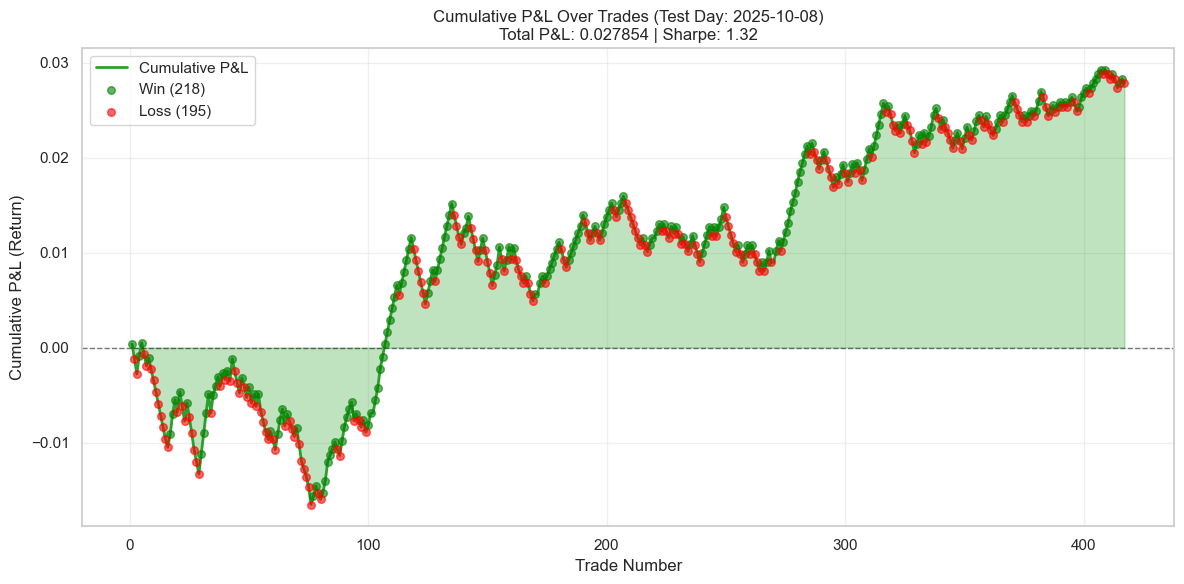

In [18]:
# VISUALIZATION 1: Cumulative P&L Over Trades
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by timestamp and compute cumulative P&L
df_sorted = df_trades.sort_values('t').reset_index(drop=True)
df_sorted['cumulative_pnl'] = df_sorted['pnl'].cumsum()
df_sorted['trade_num'] = range(1, len(df_sorted) + 1)

# Plot cumulative P&L
ax.plot(df_sorted['trade_num'], df_sorted['cumulative_pnl'], 
        linewidth=2, color='#2ca02c', label='Cumulative P&L')
ax.fill_between(df_sorted['trade_num'], 0, df_sorted['cumulative_pnl'],
                alpha=0.3, color='#2ca02c')

# Mark wins and losses
wins_mask = df_sorted['label'] == 1
losses_mask = df_sorted['label'] == -1

ax.scatter(df_sorted.loc[wins_mask, 'trade_num'], 
           df_sorted.loc[wins_mask, 'cumulative_pnl'],
           c='green', s=30, alpha=0.6, label=f'Win ({wins_mask.sum()})', zorder=5)
ax.scatter(df_sorted.loc[losses_mask, 'trade_num'], 
           df_sorted.loc[losses_mask, 'cumulative_pnl'],
           c='red', s=30, alpha=0.6, label=f'Loss ({losses_mask.sum()})', zorder=5)

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Trade Number')
ax.set_ylabel('Cumulative P&L (Return)')
ax.set_title(f'Cumulative P&L Over Trades (Test Day: {TEST_DAY})\n'
             f'Total P&L: {metrics["total_pnl"]:.6f} | Sharpe: {metrics["sharpe_ratio"]:.2f}')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

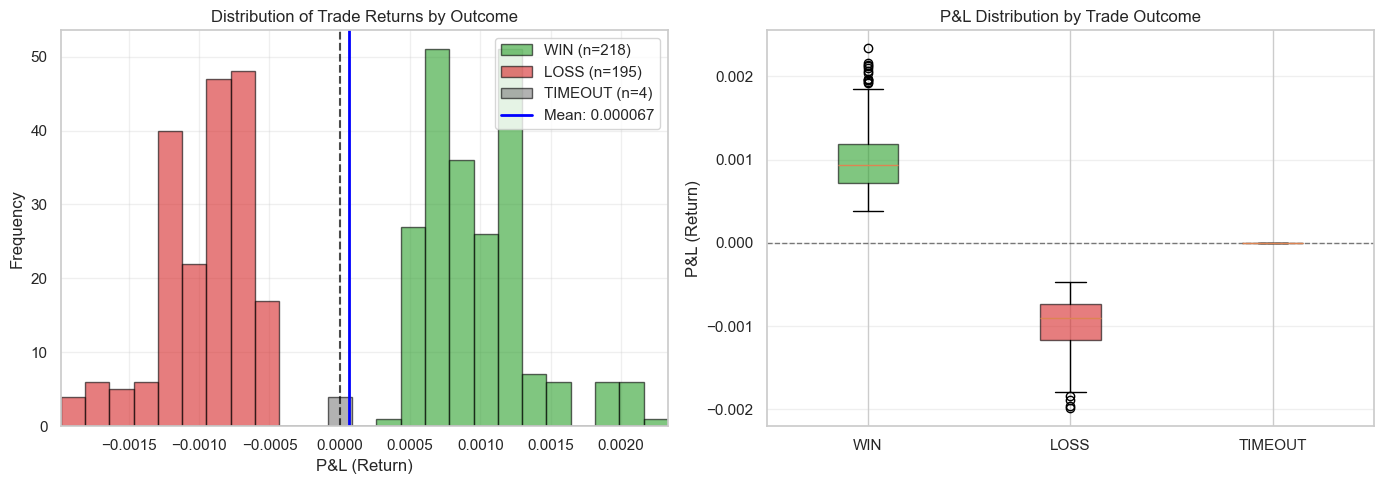


Return Statistics by Outcome:
         count      mean       std       min       max
outcome                                               
LOSS       195 -0.000971  0.000311 -0.001985 -0.000474
TIMEOUT      4  0.000000  0.000000  0.000000  0.000000
WIN        218  0.000996  0.000373  0.000382  0.002335


In [19]:
# VISUALIZATION 2: Win/Loss Distribution Histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram by outcome
ax = axes[0]
colors = {'WIN': '#2ca02c', 'LOSS': '#d62728', 'TIMEOUT': '#7f7f7f'}

# Use a common histogram range for all outcomes so they don't get rescaled
pnl_min = df_trades['pnl'].min()
pnl_max = df_trades['pnl'].max()
hist_range = (pnl_min, pnl_max)

for outcome in ['WIN', 'LOSS', 'TIMEOUT']:
    subset = df_trades[df_trades['outcome'] == outcome]['pnl']
    if len(subset) > 0:
        ax.hist(
            subset,
            bins=25,
            range=hist_range,  # lock the range across outcomes
            alpha=0.6,
            label=f'{outcome} (n={len(subset)})',
            color=colors[outcome],
            edgecolor='black'
        )

ax.set_xlim(hist_range)
ax.axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axvline(df_trades['pnl'].mean(), color='blue', linestyle='-', linewidth=2,
           label=f'Mean: {df_trades["pnl"].mean():.6f}')
ax.set_xlabel('P&L (Return)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Trade Returns by Outcome')
ax.legend()
ax.grid(alpha=0.3)

# Right: Box plot by outcome
ax = axes[1]
outcome_order = ['WIN', 'LOSS', 'TIMEOUT']
data_to_plot = [
    df_trades[df_trades['outcome'] == o]['pnl'].values
    for o in outcome_order
    if len(df_trades[df_trades['outcome'] == o]) > 0
]
labels = [
    o for o in outcome_order
    if len(df_trades[df_trades['outcome'] == o]) > 0
]

bp = ax.boxplot(data_to_plot, patch_artist=True, tick_labels=labels)
for patch, label in zip(bp['boxes'], labels):
    patch.set_facecolor(colors[label])
    patch.set_alpha(0.6)

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('P&L (Return)')
ax.set_title('P&L Distribution by Trade Outcome')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print("\nReturn Statistics by Outcome:")
print(df_trades.groupby('outcome')['pnl'].agg(['count', 'mean', 'std', 'min', 'max']).round(6))


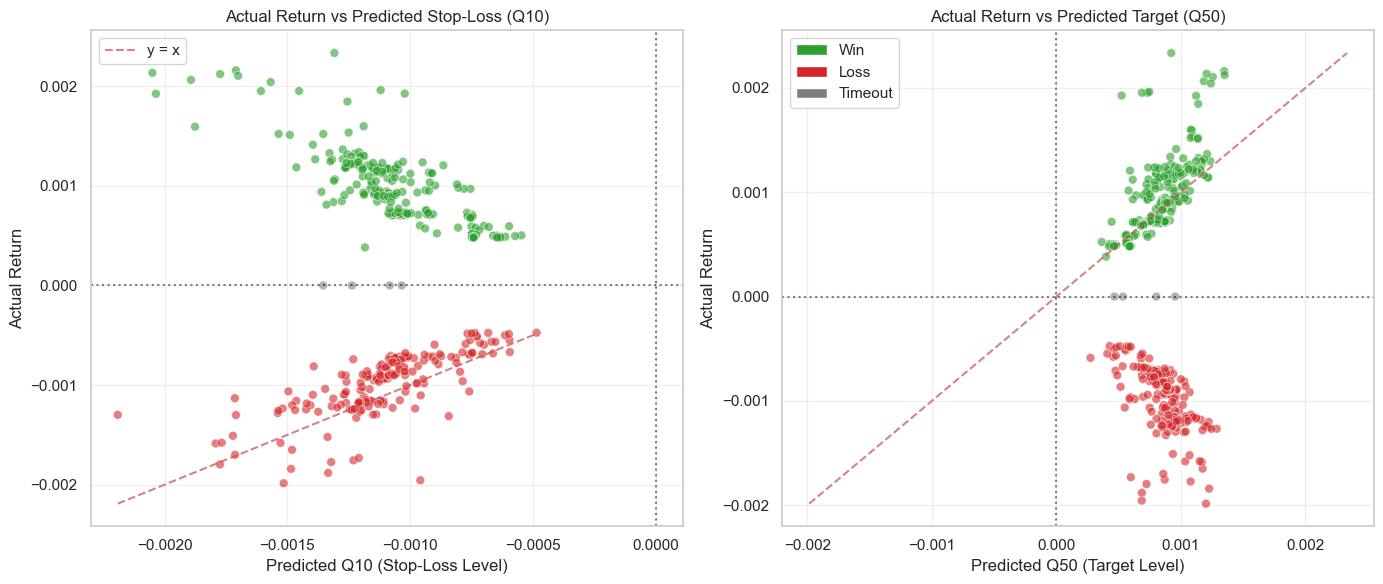


Correlation between predictions and actual returns:
  Q10 (stop) vs actual: 0.007
  Q50 (target) vs actual: 0.071


In [20]:
# VISUALIZATION 3: Predicted vs Actual Exit Levels
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Actual return vs predicted Q10 (stop-loss)
ax = axes[0]
colors_scatter = df_trades['label'].map({1: '#2ca02c', -1: '#d62728', 0: '#7f7f7f'})
ax.scatter(df_trades['pred_stop'], df_trades['pnl'], 
           c=colors_scatter, alpha=0.6, s=40, edgecolor='white', linewidth=0.5)

# Add diagonal reference
lims = [df_trades['pred_stop'].min(), df_trades['pred_stop'].max()]
ax.plot(lims, lims, 'r--', linewidth=1.5, label='y = x', alpha=0.7)
ax.axhline(0, color='black', linestyle=':', alpha=0.5)
ax.axvline(0, color='black', linestyle=':', alpha=0.5)

ax.set_xlabel('Predicted Q10 (Stop-Loss Level)')
ax.set_ylabel('Actual Return')
ax.set_title('Actual Return vs Predicted Stop-Loss (Q10)')
ax.legend()
ax.grid(alpha=0.3)

# Right: Actual return vs predicted Q50 (target)
ax = axes[1]
ax.scatter(df_trades['pred_target'], df_trades['pnl'], 
           c=colors_scatter, alpha=0.6, s=40, edgecolor='white', linewidth=0.5)

lims = [min(df_trades['pred_target'].min(), df_trades['pnl'].min()),
        max(df_trades['pred_target'].max(), df_trades['pnl'].max())]
ax.plot(lims, lims, 'r--', linewidth=1.5, label='y = x', alpha=0.7)
ax.axhline(0, color='black', linestyle=':', alpha=0.5)
ax.axvline(0, color='black', linestyle=':', alpha=0.5)

ax.set_xlabel('Predicted Q50 (Target Level)')
ax.set_ylabel('Actual Return')
ax.set_title('Actual Return vs Predicted Target (Q50)')

# Custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', label='Win'),
    Patch(facecolor='#d62728', label='Loss'),
    Patch(facecolor='#7f7f7f', label='Timeout'),
]
ax.legend(handles=legend_elements, loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlation statistics
print("\nCorrelation between predictions and actual returns:")
print(f"  Q10 (stop) vs actual: {df_trades['pred_stop'].corr(df_trades['pnl']):.3f}")
print(f"  Q50 (target) vs actual: {df_trades['pred_target'].corr(df_trades['pnl']):.3f}")

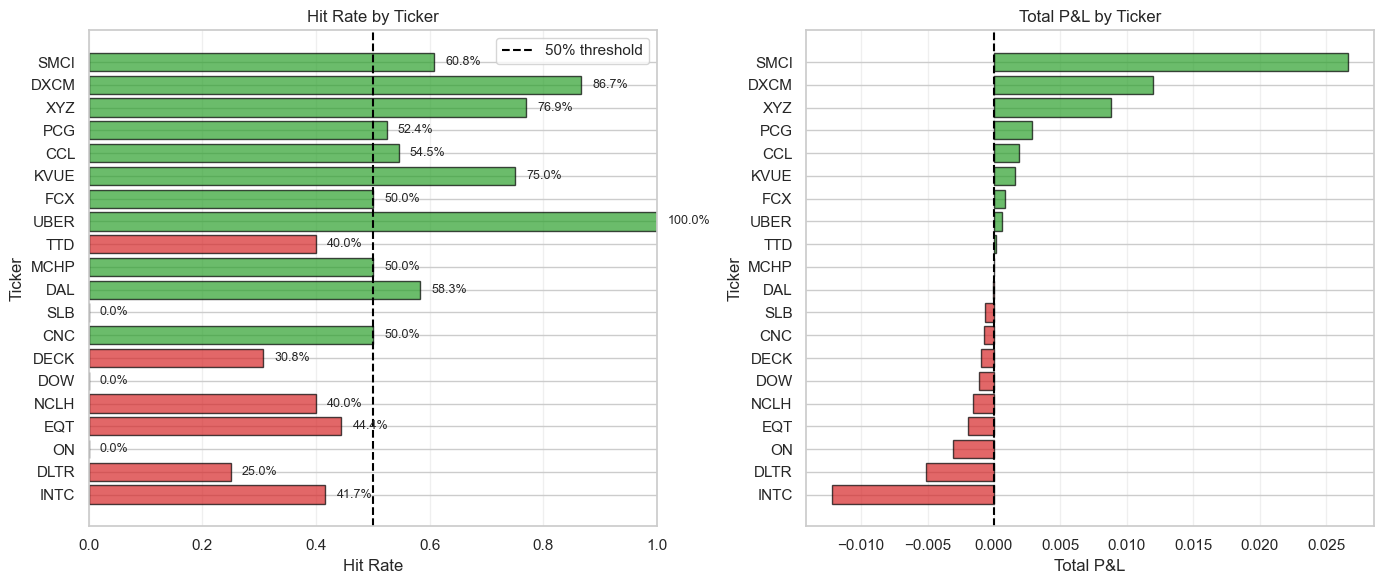


Tickers with positive P&L: 10 / 20
Tickers with hit rate > 50%: 8 / 20


In [21]:
# VISUALIZATION 4: Performance by Ticker
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sort by total P&L for display
df_plot = df_ticker_metrics.sort_values('total_pnl', ascending=True)

# Left: Hit Rate by Ticker
ax = axes[0]
colors_bar = ['#2ca02c' if x >= 0.5 else '#d62728' for x in df_plot['hit_rate']]
bars = ax.barh(df_plot['ticker'], df_plot['hit_rate'], color=colors_bar, alpha=0.7, edgecolor='black')
ax.axvline(0.5, color='black', linestyle='--', linewidth=1.5, label='50% threshold')
ax.set_xlabel('Hit Rate')
ax.set_ylabel('Ticker')
ax.set_title('Hit Rate by Ticker')
ax.set_xlim(0, 1)
ax.legend()
ax.grid(alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, df_plot['hit_rate']):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2,
            f'{val:.1%}', va='center', fontsize=9)

# Right: Total P&L by Ticker
ax = axes[1]
colors_bar = ['#2ca02c' if x >= 0 else '#d62728' for x in df_plot['total_pnl']]
bars = ax.barh(df_plot['ticker'], df_plot['total_pnl'], color=colors_bar, alpha=0.7, edgecolor='black')
ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
ax.set_xlabel('Total P&L')
ax.set_ylabel('Ticker')
ax.set_title('Total P&L by Ticker')
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print summary
print(f"\nTickers with positive P&L: {(df_ticker_metrics['total_pnl'] > 0).sum()} / {len(df_ticker_metrics)}")
print(f"Tickers with hit rate > 50%: {(df_ticker_metrics['hit_rate'] > 0.5).sum()} / {len(df_ticker_metrics)}")

## 5. Summary

In [14]:
# Generate report text output
print("="*80)
print("REPORT OUTPUT: Full Pipeline Performance Summary")
print("="*80)

print(f"""
### Full Pipeline Results (Out-of-Sample)

The full trading pipeline was evaluated on the held-out test day (October 8, 2025) 
using {metrics['n_trades']} trades that passed both the GMM overextension filter 
and the RF probability threshold (>= {RF_THRESHOLD}).

**Summary Metrics:**

| Metric | Value |
|--------|-------|
| Total Trades | {metrics['n_trades']} |
| Wins / Losses / Timeouts | {metrics['n_wins']} / {metrics['n_losses']} / {metrics['n_timeouts']} |
| Hit Rate | {metrics['hit_rate']:.1%} |
| Win/Loss Ratio | {metrics['win_loss_ratio']:.2f} |
| Total P&L | {metrics['total_pnl']:.6f} ({metrics['total_pnl']*10000:.2f} bps) |
| Mean P&L per Trade | {metrics['mean_pnl']:.6f} |
| Sharpe Ratio | {metrics['sharpe_ratio']:.2f} |

**Interpretation:**

- A hit rate of {metrics['hit_rate']:.1%} indicates that approximately {int(metrics['hit_rate']*100)}% 
  of predicted mean-reversion opportunities successfully reached their profit targets.
- The win/loss ratio of {metrics['win_loss_ratio']:.2f} shows the average winning trade 
  {'outperformed' if metrics['win_loss_ratio'] > 1 else 'underperformed'} the average losing trade.
- The Sharpe ratio of {metrics['sharpe_ratio']:.2f} suggests {'favorable' if metrics['sharpe_ratio'] > 1 else 'modest'} 
  risk-adjusted returns on the test day.
""")

# Per-ticker summary
top_tickers = df_ticker_metrics.head(3)
bottom_tickers = df_ticker_metrics.tail(3)

print(f"\n**Top 3 Performers:**")
for _, row in top_tickers.iterrows():
    print(f"- {row['ticker']}: {row['hit_rate']:.1%} hit rate, P&L = {row['total_pnl']:.6f}")

print(f"\n**Bottom 3 Performers:**")
for _, row in bottom_tickers.iterrows():
    print(f"- {row['ticker']}: {row['hit_rate']:.1%} hit rate, P&L = {row['total_pnl']:.6f}")

REPORT OUTPUT: Full Pipeline Performance Summary

### Full Pipeline Results (Out-of-Sample)

The full trading pipeline was evaluated on the held-out test day (October 8, 2025) 
using 417 trades that passed both the GMM overextension filter 
and the RF probability threshold (>= 0.3).

**Summary Metrics:**

| Metric | Value |
|--------|-------|
| Total Trades | 417 |
| Wins / Losses / Timeouts | 218 / 195 / 4 |
| Hit Rate | 52.3% |
| Win/Loss Ratio | 1.03 |
| Total P&L | 0.027854 (278.54 bps) |
| Mean P&L per Trade | 0.000067 |
| Sharpe Ratio | 1.32 |

**Interpretation:**

- A hit rate of 52.3% indicates that approximately 52% 
  of predicted mean-reversion opportunities successfully reached their profit targets.
- The win/loss ratio of 1.03 shows the average winning trade 
  outperformed the average losing trade.
- The Sharpe ratio of 1.32 suggests favorable 
  risk-adjusted returns on the test day.


**Top 3 Performers:**
- SMCI: 60.8% hit rate, P&L = 0.026667
- DXCM: 86.7% hit rate, P

In [15]:
# Generate HTML table for direct inclusion in report
print("\n" + "="*80)
print("HTML TABLE OUTPUT (for index.html)")
print("="*80)

html_table = f"""
<table>
    <caption><strong>Full Pipeline Performance (Out-of-Sample, Oct 8, 2025)</strong></caption>
    <thead>
        <tr>
            <th>Metric</th><th>Value</th>
        </tr>
    </thead>
    <tbody>
        <tr><td>Total Trades</td><td>{metrics['n_trades']}</td></tr>
        <tr><td>Wins / Losses / Timeouts</td><td>{metrics['n_wins']} / {metrics['n_losses']} / {metrics['n_timeouts']}</td></tr>
        <tr><td>Hit Rate</td><td>{metrics['hit_rate']:.1%}</td></tr>
        <tr><td>Win/Loss Ratio</td><td>{metrics['win_loss_ratio']:.2f}</td></tr>
        <tr><td>Total P&L</td><td>{metrics['total_pnl']:.6f}</td></tr>
        <tr><td>Mean P&L per Trade</td><td>{metrics['mean_pnl']:.6f}</td></tr>
        <tr><td>Sharpe Ratio</td><td>{metrics['sharpe_ratio']:.2f}</td></tr>
    </tbody>
</table>
"""
print(html_table)


HTML TABLE OUTPUT (for index.html)

<table>
    <caption><strong>Full Pipeline Performance (Out-of-Sample, Oct 8, 2025)</strong></caption>
    <thead>
        <tr>
            <th>Metric</th><th>Value</th>
        </tr>
    </thead>
    <tbody>
        <tr><td>Total Trades</td><td>417</td></tr>
        <tr><td>Wins / Losses / Timeouts</td><td>218 / 195 / 4</td></tr>
        <tr><td>Hit Rate</td><td>52.3%</td></tr>
        <tr><td>Win/Loss Ratio</td><td>1.03</td></tr>
        <tr><td>Total P&L</td><td>0.027854</td></tr>
        <tr><td>Mean P&L per Trade</td><td>0.000067</td></tr>
        <tr><td>Sharpe Ratio</td><td>1.32</td></tr>
    </tbody>
</table>



In [16]:
print("\n" + "="*60)
print("FULL PIPELINE EVALUATION - COMPLETE")
print("="*60)
print(f"\nTest Day: {TEST_DAY}")
print(f"Total Trades: {metrics['n_trades']}")
print(f"Hit Rate: {metrics['hit_rate']:.1%}")
print(f"Win/Loss Ratio: {metrics['win_loss_ratio']:.2f}")
print(f"Total P&L: {metrics['total_pnl']:.6f}")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
print(f"\nVisualization files saved to: docs/assets/img/")
print(f"  - fullPipeline_cumulative_pnl.png")
print(f"  - fullPipeline_return_distribution.png")
print(f"  - fullPipeline_predicted_vs_actual.png")
print(f"  - fullPipeline_performance_by_ticker.png")


FULL PIPELINE EVALUATION - COMPLETE

Test Day: 2025-10-08
Total Trades: 417
Hit Rate: 52.3%
Win/Loss Ratio: 1.03
Total P&L: 0.027854
Sharpe Ratio: 1.32

Visualization files saved to: docs/assets/img/
  - fullPipeline_cumulative_pnl.png
  - fullPipeline_return_distribution.png
  - fullPipeline_predicted_vs_actual.png
  - fullPipeline_performance_by_ticker.png
